# Esercizi 08 - Quantum Monte Carlo

<span style="color:blue">
Il potenziale considerato è $$V(x)=x^4-\frac{5}{2}x^2$$
La funzione di prova, invece, è $$\Psi_{T}^{\mu,\sigma}\propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$
</span>

<span style="color:blue">Discretizzando l'equazione di Schrödinger, si possono ottenere autovettori e autovalori con cui confrontare i risultati che saranno ottenuti in seguito.</span>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 400 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)


## Esercizio 08.1

L'obiettivo è calcolare

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

La distribuzione che vogliamo campionare sarà quindi
<span style="color:red">
$$p^{\mu,\sigma}(x) = |{\psi}_{T}^{\mu,\sigma}(x)|^2 \propto \left(e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}\right)^2$$
</span>

Mentre la funzione da valutare (l'energia locale) sarà  
$$E_{loc}(x)=\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}=\frac{-\frac{1}{2}\Psi''_T(x)+V(x)\Psi_T(x)}{\Psi_T(x)}=-\frac{\Psi''_T(x)}{2\Psi_T(x)}+V(x)$$

In particolare
$$\frac{\Psi''_T(x)}{\Psi_T(x)}=\frac{e^{-\frac{(x-\mu)^2}{2\sigma^2}}\left(\frac{(x-\mu)^2-\sigma^2}{\sigma^4} \right)+e^{-\frac{(x+\mu)^2}{2\sigma^2}}\left(\frac{(x+\mu)^2-\sigma^2}{\sigma^4} \right)}{e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}}=\frac{e^{-\frac{(x-\mu)^2}{2\sigma^2}}(x-\mu)^2+e^{-\frac{(x+\mu)^2}{2\sigma^2}}(x+\mu)^2-\sigma^2\left(e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}} \right)}{\sigma^4\left(e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}\right)}=\frac{x^2+\mu^2-2\mu x\left(\frac{e^{-\frac{(x-\mu)^2}{2\sigma^2}}-e^{-\frac{(x+\mu)^2}{2\sigma^2}}}{e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}}\right)-\sigma^2}{\sigma^4}=\frac{x^2+\mu^2-2\mu x\left(\frac{e^{\frac{\mu x}{\sigma^2}}-e^{-\frac{\mu x}{\sigma^2}}}{e^{\frac{\mu x}{\sigma^2}}+e^{-\frac{\mu x}{\sigma^2}}}\right)-\sigma^2}{\sigma^4}=\frac{x^2+\mu^2-\sigma^2-2\mu x \tanh(\frac{\mu x}{\sigma^2})}{\sigma^4}$$

Alla fine, l'energia locale, ossia la funzione di cui bisognerà calcolare l'integrale con distribuzione di probabilità  $p(x)$, è

<span style="color:red">
$$E_{loc}(x)=-\frac{x^2+\mu^2-\sigma^2-2\mu x \tanh(\frac{\mu x}{\sigma^2})}{2\sigma^4}+x^4-\frac{5}{2}x^2$$
</span>

Ho inoltre provato a implementare il Langevin Monte Carlo, per cui è necessaria la derivata logaritmica della distribuzione di probabilità da campionare:

$$\ln{p(x)}=2\ln{|\Psi_T(x)|}$$
<span style="color:red">
$$\frac{d}{dx}\ln{p(x)}=2\frac{\Psi'_T(x)}{\Psi_T(x)}=\dots=-\frac{2(x-\mu \tanh(\frac{\mu x}{\sigma^2}))}{\sigma^2}$$
</span>

Per la scelta della probabilità di transizione tentativo si sono considerate due distribuzioni di probabilità:
* $T(x|y)$ uniforme: $x = unif(y - \delta, y+\delta)$, dove $\delta$ è il parametro da modificare per regolare      la probabilità di accettazione.
* Smart Monte Carlo: considerando un processo di diffusione con un termine di drift proporzionale alla derivata logaritmica della distribuzione di probabilità che si vuole campionare $p(x)$, si può dimostrare che quest'ultima risulta essere una soluzione stazionaria dell'equazione di Fokker-Planck. Le traiettorie corrispondenti a questo processo di diffusione si possono ottenere considerando un moto browniano con un termine di drift. Tuttavia, nel procedimento vengono introdotti degli errori con le approssimazioni fatte per discretizzare il processo stocastico e per ricavare l'equazione di Fokker-Planck. Campionando questo moto browniano otterremmo quindi qualcosa di simile a $p(x)$, ma non esattamente $p(x)$. Si può ovviare a questo problema con l'algoritmo di Metropolis, implementando quindi una forma di importance sampling. Proporremo delle mosse corrispondenti a un moto browniano con drift, ovvero
  $$T(x|y)=\exp{-\frac{(x-y-\frac{\tau^2}{2}\frac{d}{dx}\ln{p(y)})^2}{2\tau^2}}$$
  cioè campionando una gaussiana con media $\mu=y+\frac{\tau^2}{2}\frac{d}{dx}\ln{p(y)}$ e varianza $\tau^2$ (che sappiamo essere "simile" a quella che vogliamo campionare), dove $\tau$ è un parametro che determina la "larghezza" delle mosse. Per avere garantita la convergenza a $p(x)$ accetteremo queste mosse con probabilità
  $$A(x|y)=\min\left(1,\frac{T(y|x)p(x)}{T(x|y)p(y)}\right)$$
  In questo caso la probabilità di transizione non è simmetrica. Pertanto bisogna anche calcolare
  $$T(y|x)=\exp{-\frac{(y-x-\frac{\tau^2}{2}\frac{d}{dx}\ln{p(x)})^2}{2\tau^2}}$$

## Scelta larghezza distribuzione

Per avere un'idea di che valori scegliere per $\delta$ e $\tau$, ho cominciato a considerare uno stato di prova con $\mu=1$ e $\sigma=0.75$, che, considerata la forma del potenziale, sono parametri versoimili per lo stato di prova a minima energia.


Ho riscontrato qualche problema nel raggiugere il $50\%$ di accettazione con il Langevin Monte Carlo e ho ipotizzato una spiegazione. La distribuzione di probabilità che vogliamo campionare decade come molto velocemente, andando a zero come $\sim e^{-x^2}$. La sua derivata logaritmica, sarà lineare. Ho notato che questo comporta dei problemi se viene estratto un punto corrispondenta a una zona con probabilità bassa. In questo caso il punto successivo viene estratto da una gaussiana centrata in $y+\frac{\tau^2}{2}\frac{d}{dx}\ln{p(y)}$, ovvero viene corretto l'ultimo punto con un termine di drift, che tende a dirigere l'estrazione verso zone più probabili. Il problema nasce dal fatto che, <span style="color:red">se $\tau$ è troppo grande, il termine di drift "corregge troppo" il valor medio della gaussiana da campionare. I punti successivi, quindi verranno estratti dalla parte opposta rispetto all'ultimo punto, ma in zone troppo lontane dalla distribuzione di probabilità che vogliamo campionare e saranno quindi rigettati</span>. Facendo un esempio con dei numeri scelti a tavolino si può forse spiegare meglio il problema. Supponiamo che a un certo punto il nostro algoritmo di Metropolis arrivi ad estrarre $y=2.5$, un punto lontano dalle zone più probabili, ma comunque raggiungibile facendo un numero sufficiente di estrazioni. Calcolando il valore della derivata logaritmica $\frac{d}{dx}\ln{p(2.5)}\approx-3$ ci si rende conte che l'algoritmo vorrebbe correggere molto questo valore. Nello specifico, considerando ad esempio $\tau=2$, il valor medio della gaussiana da cui verrà estratto il punto successivo sarà $y+\frac{\tau^2}{2}\frac{d}{dx}\ln{p(y)}\approx -4$, in media verrà quindi estratto un punto meno buono del precedente, che già non era molto probabile. Succede quindi che l'algoritmo tende a bloccarsi sul valore $2.5$ (o, peggio, su un valore estratto peggiore) alterando quindi il campionamento della distribuzione di probabilità. Questo ragionamento mi ha indotto a non prendere in considerazione un target per il valore di accettazione: posso semplicemente regolare il parametro $\tau$ in modo che le mosse siano abbastanza piccole, ovvero considerando una discretizzazione più fine della dinamica. Ovviamente, se le gaussiane risulteranno più piccate, bisognerà diminuire il valore di $\tau$. 

Per fare un primo confronto tra i due metodi, ho considerato <span style="color:red">$\tau=0.75$</span>, con cui ho ottenuto un'accettanza circa del $85\%$. Invece, utilizzando una probabilità di transizione uniforme, utilizzando <span style="color:red">$\delta=3$</span> si ottiene $\alpha\approx0.53$. 

Il valore di $\tau=0.75$ è stato scelto per tentativi, scegliendo un valore che minimizzasse l'incertezza finale. È sufficiente un'ottimizzazione molto grezza, ma questo è l'unico criterio che ho individuato per scegliere un "buon" valore di $\tau$.


<span style="color:red">Come punto iniziale ho considerato come $x=\mu$</span>: non sempre è un massimo della distribuzione di probabilità (se le due gaussiane di $\Psi_T^{\sigma,\mu}$ sono sufficientemente larghe e vicine, il massimo di $p(x)$ si ottiene in $x=0$), ma è sempre un punto abbastanza buono, mentre $x=0$ potrebbe non esserlo se le gaussiane sono ben separate e strette.


Considerando $M=10^{6}$ step e $N=100$ blocchi da $10000$ punti ciascuno, ho ottenuto i seguenti risultati 

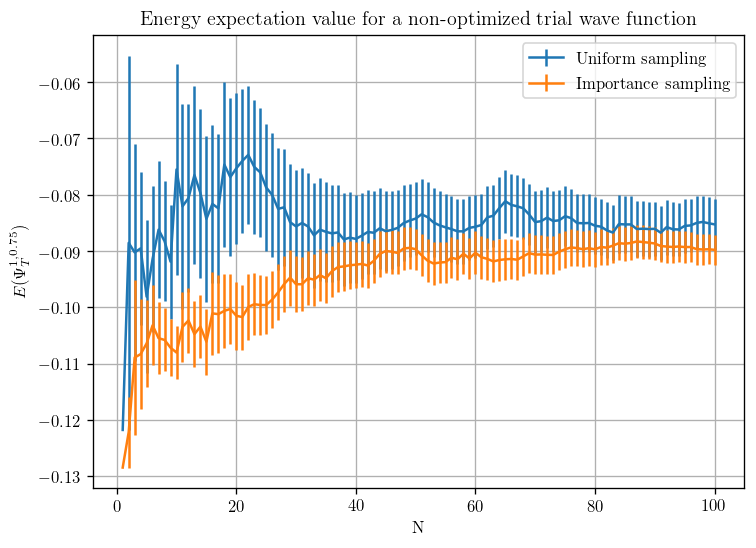

Uniform sampling: -0.0852864 +/- 0.00456894
Importance sampling: -0.0898038 +/- 0.00266663


In [2]:
n_unif,avg_unif,err_unif=np.loadtxt("Ex_08_1/out_eunif.txt", delimiter=",", skiprows=1, usecols=(0,1,2), dtype="int,float,float", unpack=True)
n_imp,avg_imp,err_imp=np.loadtxt("Ex_08_1/out_esmart.txt", delimiter=",", skiprows=1, usecols=(0,1,2), dtype="int,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(7,5),dpi=120)
#plt.hlines(1,0,100)
plt.title("Energy expectation value for a non-optimized trial wave function")
plt.errorbar(n_unif,avg_unif,yerr=err_unif, label="Uniform sampling")
plt.errorbar(n_imp,avg_imp,yerr=err_imp, label="Importance sampling")
plt.grid()
plt.xlabel("N")
plt.ylabel(r"$E(\Psi_T^{1,0.75})$")
plt.legend()
plt.show()
print("Uniform sampling: "+str(avg_unif[-1])+" +/- "+str(err_unif[-1]))
print("Importance sampling: "+str(avg_imp[-1])+" +/- "+str(err_imp[-1]))


Come si può notare, <span style="color:red">l'incertezza con l'importance sampling, a parità di blocchi considerati, è poco più della metà di quella ottenuta con un campionamento uniforme</span>. Inoltre, <span style="color:red">l'incertezza finale raggiunta con il sampling uniforme è stata raggiunta dopo solo circa $30$ blocchi con l'importance sampling</span>. Questo sembra indicare che il vantaggio dell'importance sampling aumenta se si considerano pochi blocchi. Questo miglioramento può essere molto utile per ottimizzare il simulated annealing discusso nel punto successivo. 

## Ottimizzazione dei parametri - Simulated annealing e reweighting

Per trovare i parametri $\mu$ e $\sigma$ che minimizzano $\langle \hat{H} \rangle_T$ ho provato a implentare il **simulated annealing**. L'idea è di provare a cambiare casualmente i parametri $\mu$ e $\sigma$, accettando ogni mossa con una certa probabilità determinata utilizzando dei pesi di Boltzmann $e^{-\beta E_{\mu,\sigma}}$, dove $E$ è l'energia corrispondente allo stato considerato, mentre $\beta$ ha la funzione dell'inverso della temperatura in termodinamica. Aumentando $\beta$ (ovvero facendo tendere la temperatura a $0$) nel corso della simulazione, arriverò a uno stato che minimizza il valore di aspettazione dell'energia per la classe di stati considerati $\psi_T^{\mu,\sigma}$.

Ho implementanto il simulated annealing nel seguente modo:

0. Considero una configurazione $(\sigma_{old},\mu_{old})$ e un certo valore di $\beta$.
1. Estraggo una coppia $(\sigma_{new}, \mu_{new})$
2. Calcolo $E_{new}=\langle \hat{H} \rangle_{T,new}$
3. Accetto i nuovi valori $(\sigma_{new}, \mu_{new})$ con probabilità $\alpha=\min(1,\frac{e^{-\beta E_{new}}}{e^{-\beta E_{old}}})$
4. Riprendo dal punto iniziale. Il loop viene fermato dopo $N_{\beta}$ step. Alla fine di ogni loop, aumento $\beta$ (abbasso la temperatura) e riprendo dall'inizio considerando come configurazione iniziale l'ultima raggiunta. 

Il punto più critico consiste ovviamente nel fatto che a ogni step devo calcolare un nuovo valore di aspettazione dell'energia. Tuttavia, dato che le distribuzione di probabilità che vogliamo campionare saranno tutte abbastanza simili, si può sfruttare la tecnica del **reweighting**. In questo caso può essere particolarmente utile: <span style="color:red">dato che vogliamo minimizzare dei parametri, andremo a valutare funzioni che, pur dipendendo da $\mu$ e $\sigma$, non saranno molto diverse le une dalle altre</span>. In questo modo si può evitare di campionare tutti i punti ad ogni stima dell'energia dello stato corrispondente a una nuova coppia di valori $(\mu,\sigma)$. Il reweighting si può implementare in due modi: si può fare un unico campionamento iniziale oppure si può decidere di effettuare un ricampionamento ad ogni cambio di temperatura. Ho utilizzato quest'ultimo metodo in quanto mi è sembrato un ragionevole compromesso tra il campionare ad ogni step e il campionare una sola volta (approccio che comunque non dà particolari problemi in questo caso, data la semplicità del sistema).

Adottando la tecnica del reweighting, il costo del calcolo è determinato principalmente dalle valutazioni di $E_{loc}^{\mu,\sigma}$ e di $p^{\mu,\sigma}(x)$, dove $\mu$ e $\sigma$ sono una nuova coppia di parametri che bisogna valutare se accettare o meno (la distribuzione di probabilità rispetto corrispondente ai parametri utilizzati per il campionamento iniziale possono essere memorizzati in un vettore per evitare di ricalcolarli ad ogni valutazione dell'energia, migliorando così l'efficienza). Lo smart Monte Carlo introdotto prima può quindi essere utile: <span style="color:red">l'energia che calcoliamo ogni volta per accettare o rifiutare la proposta di $(\mu, \sigma)$ è affetta da una certa incertezza statistica, potrebbe quindi succedere che una mossa venga accettata o rifiutata solo perché l'energia non era stata stimata con sufficiente precisione</span>. Come detto prima, a parità di passi, l'incertezza sull'energia calcolata <span style="color:red">con il Langevin Monte Carlo</span> è circa la metà di quella ottenuta con una probabilità di transizione uniforme; pertanto, <span style="color:red">possiamo utilizzare meno step senza perdere precisione</span>. Questo è vantaggioso in quanto riduce le valutazioni di $E_{loc}^{\mu,\sigma}$ e di $p^{\mu,\sigma}(x)$ che bisogna fare a ogni proposta di $(\mu, \sigma)$. Per avere un'idea delle incertezze in gioco, al punto precedente dopo $10^5$ step (quindi dopo $10$ blocchi), l'incertezza sull'energia calcolata con il sampling uniforme era $\approx 0.018$, mentre quella calcolata con l'importance sampling era $\approx 0.006$.

Per implementare il simulated annealing ho scelto una temperatura iniziale infinita, ovvero $\beta_{in}=0$, e ho effettuato $200$ cambi di temperatura in step da $\Delta \beta=10$ (quindi ho considerato sitemi a <span style="color:red">$\beta=0,10,20,\dots,2000$</span>). Si noti che avendo scelto una temperatura infinita come temperatura iniziale, il primo passo in realtà potrebbe peggiorare la nostra stima "ad occhio" dei parametri iniziali, mi è sembrato comunque interessante inserire questo peggioramento appositamente in modo da partire in una condizione più verosimile (in casi più complicati potrebbe non essere facile stimare dei parametri iniziali ragionevoli così facilmente). 

<span style="color:red">Per ogni temperatura considerata, ho considerato $100$ estrazioni di $(\mu, \sigma)$</span>. Per l'estrazione di $\mu$ e $\sigma$ ho considerato una probabilità di transizione uniforme con larghezza $\delta=0.05$ per entrambi.

Infine, ho utilizzato $10^5$ passi per ogni stima dell'energia, utilizzando una larghezza $\tau=0.75$ per il campionamento iniziale che viene poi riutilizzato per il reweighting. 

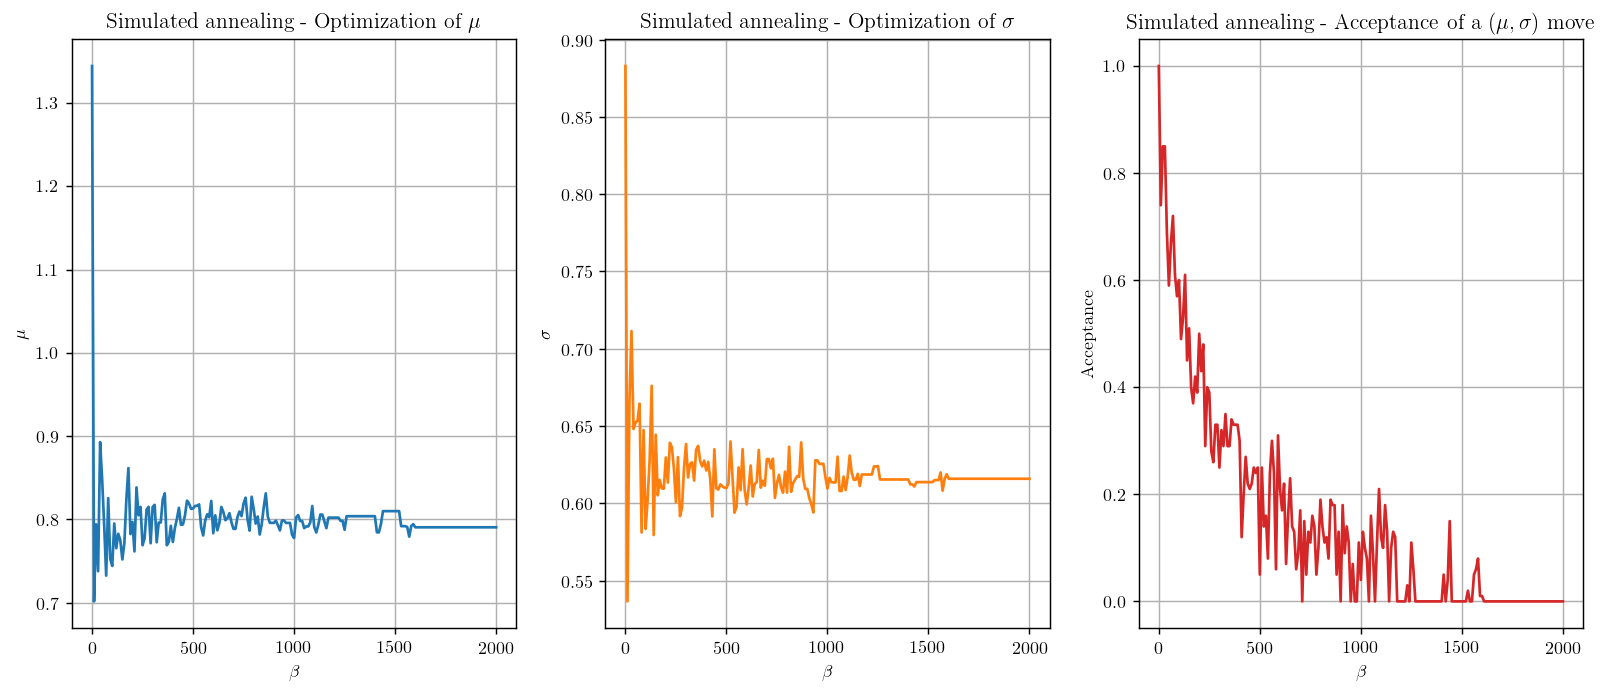

Optimal mu: 0.790331
Optimal sigma: 0.615876


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

beta, mu, sigma, energy, energy_err, acceptance=np.loadtxt("Ex_08_2/annealing.out", delimiter=",", skiprows=1, usecols=(0,2,3,4,5,6), dtype="float,float,float,float,float,float", unpack=True)
optimal_parameters= np.loadtxt("Ex_08_2/optimalmusigma.out")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,6), dpi=130)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.plot(beta,mu)
ax1.set_title(r"Simulated annealing - Optimization of $\mu$")
ax1.set_xlabel(r"$\beta$")
ax1.set_ylabel(r"$\mu$")
ax2.plot(beta,sigma, color="C1")
ax2.set_title(r"Simulated annealing - Optimization of $\sigma$")
ax2.set_xlabel(r"$\beta$")
ax2.set_ylabel(r"$\sigma$")

ax3.plot(beta,acceptance,color="C3")
ax3.set_title(r"Simulated annealing - Acceptance of a $(\mu,\sigma)$ move")
ax3.set_xlabel(r"$\beta$")
ax3.set_ylabel(r"Acceptance")

plt.show()

print("Optimal mu: "+str(optimal_parameters[0]))
print("Optimal sigma: "+str(optimal_parameters[1]))


Come si può notare il primo passo peggiora effettivamente la nostra stima iniziale di $\mu_0=1$ e $\sigma_0=0.75$. Nonostante questo l'algoritmo torna subito su valori più appropriati. Si può anche notare che, per il primo passo, l'accettazione per una mossa di $(\mu,\sigma)$ è pari al $100 \%$ (come atteso, dato che $\beta=0$ e che per l'accettazione vengono usati dei pesi di Boltzmann). <span style="color:red">All'aumentare di $\beta$, ovvero al diminuire della temperatura, le fluttuazioni sui parametri $\mu$ e $\sigma$ diminuiscono </span> (nei grafici $\mu$ e $\sigma$ sono i valori finali ottenuti ad ogni temperatura considerata); <span style="color:red">inoltre l'accettazione tende a diminuire</span>, ovvero diventa sempre più difficile trovare una mossa di $(\mu, \sigma)$ migliore (i pesi di Boltzmann diventano sempre più rilevanti e i valori dei parametri si avvicinano sempre di più a quelli che minimizzano effettivamente l'energia). Infine, circa <span style="color:red">a $\beta=1500$, il sistema si "congela" su dei parametri $\mu$ e $\sigma$, che saranno quelli considerati ottimali</span>; coerentemente, l'accettanza si riduce a zero. 

Ovviamente le cose si potrebbero complicare a piacere. Ad esempio, si potrebbe decidere di cambiare i parametri della simulazione in corso: al variare di $\beta$ (che potrebbe anche non variare in modo costante come fatto qui) si potrebbe regolare l'ampiezza delle mosse per $\mu$, $\sigma$ e il numero di step utilizzati per campionare la distribuzione di probabilità, in modo da stimare i parametri con maggiore precisione.

Ho infine utilizzato i valori ottimali così trovati <span style="color:red">$\mu=0.790331$</span> e <span style="color:red">$\sigma=0.615876$</span> per campionare la distribuzione di probabilità corrispondente e calcolare l'energia. Questa volta ho utilizzato $\tau=0.5$ (le gaussiane sono più strette rispetto a quelle utilizzate nel punto iniziale, quindi è ragionevole che sia opportuno fare delle mosse più piccole), e $N=10^7$ campionamenti divisi in $100$ blocchi da $10^5$ misure ciascuno. Per la distribuzione di probabilità ho considerato un istogramma di 400 bin.

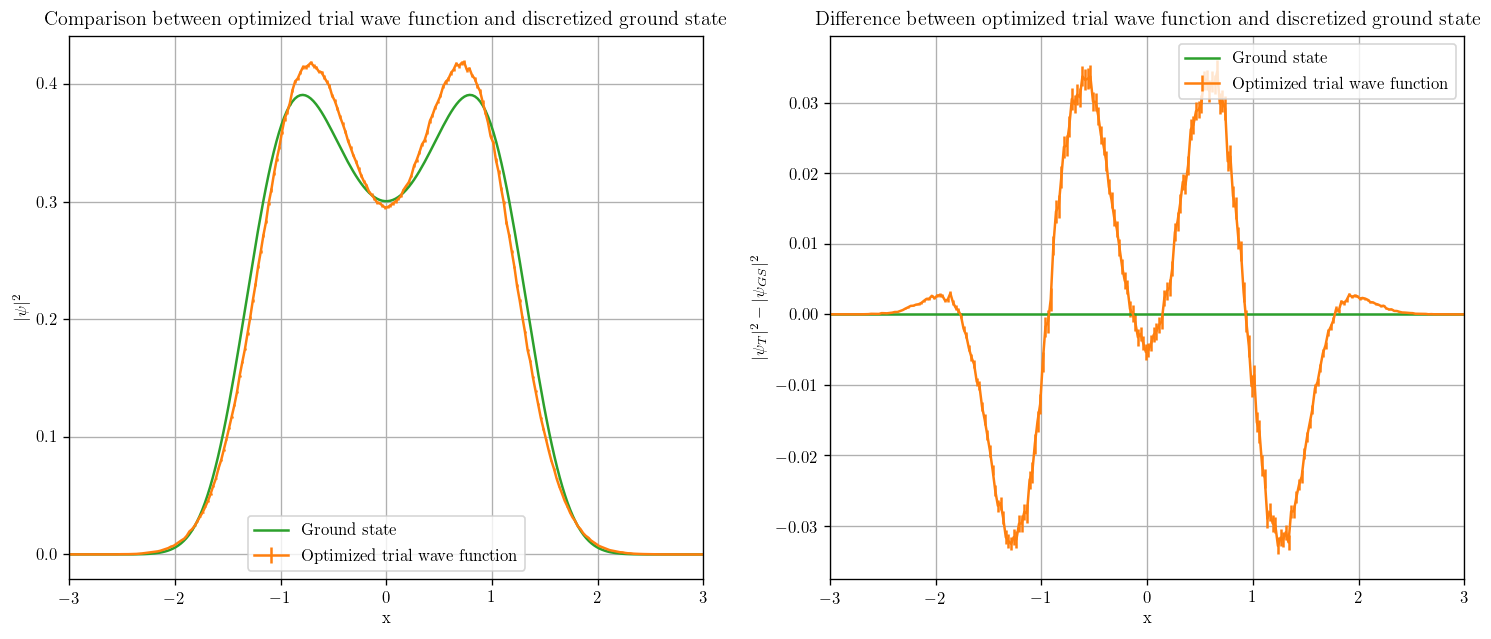

In [17]:
xsampl, psampl, psampl_err=np.loadtxt("Ex_08_2/probabilitydistribution.out", delimiter=",", skiprows=1, dtype="float,float,float", unpack=True)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.grid(True)
ax1.set_title("Comparison between optimized trial wave function and discretized ground state")
ax1.set_xlabel("x")
ax1.set_ylabel(r"$|\psi|^2$")
ax1.errorbar(xsampl,psampl,yerr=psampl_err, label="Optimized trial wave function", color="C1")
ax1.plot(x,(psi[0])**2, color="C2", label="Ground state")
ax1.set_xlim((-3,3))
ax1.legend()

ax2.grid(True)
ax2.set_title("Difference between optimized trial wave function and discretized ground state")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$|\psi_T|^2-|\psi_{GS}|^2$")
ax2.errorbar(xsampl,psampl-(psi[0])**2,yerr=psampl_err, label="Optimized trial wave function", color="C1")
ax2.axhline(0,0,1, color="C2", label="Ground state")
ax2.set_xlim((-3,3))
ax2.legend()

plt.show()

Nei grafici sopra è riportato un confronto tra la distribuzione di probabilità campionata con lo smart Monte Carlo (in arancione) con quella ottenuta calcolando gli autovettori discretizzando l'equazione di Schrödinger (in verde). In particolare nel grafico a destra si possono osservare le zone in cui la differenza tra le due distribuzioni di probabilità è maggiore (per la distribuzione di probabilità della funzione d'onda di prova sono state calcolate anche le incertezze punto per punto con il data blocking). In seguito riporto un confronto tra i valori di aspettazione per l'energia.

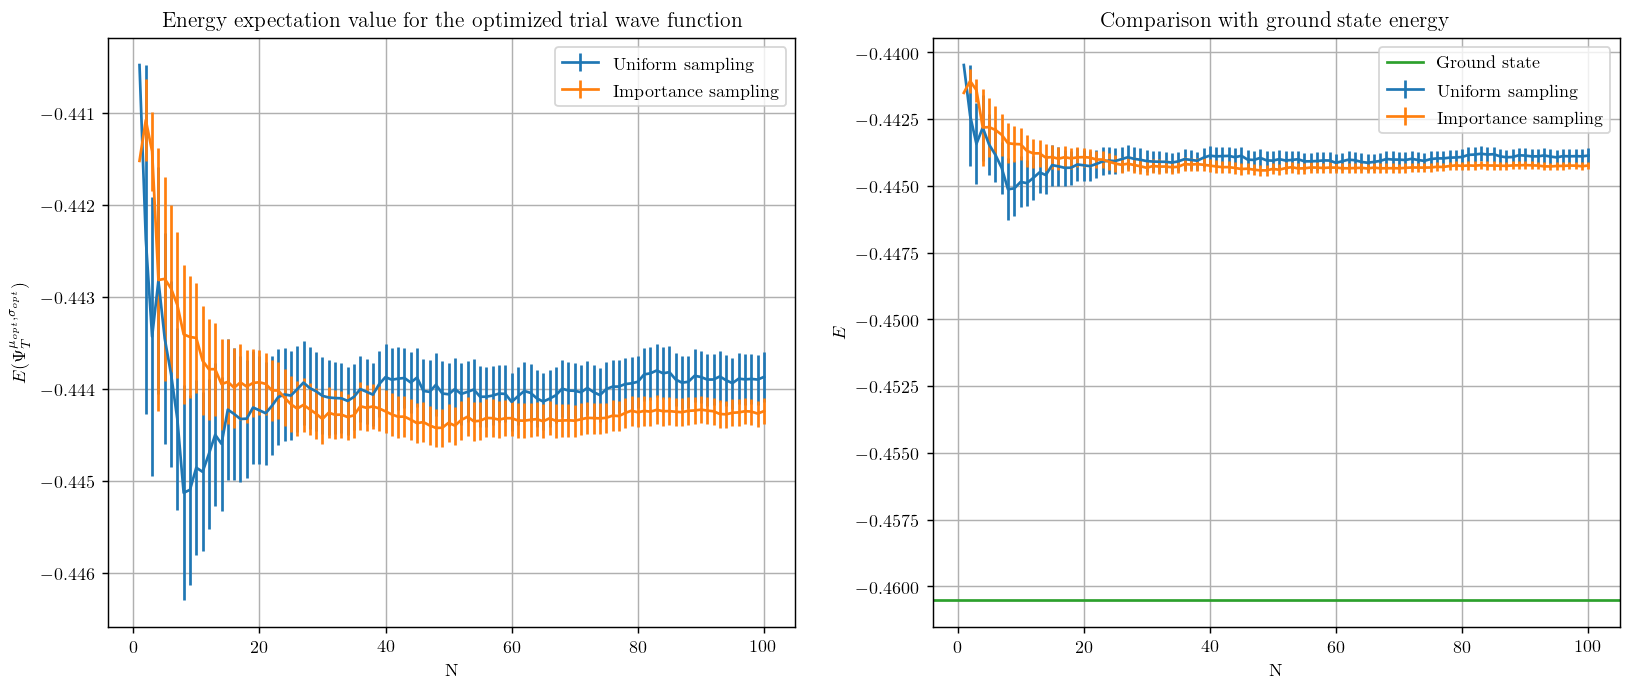

Uniform sampling:  -0.443869  +/-  0.000269972
Importance sampling:  -0.444241  +/-  0.000142623
Ground state energy:  -0.46052678306551875


In [5]:
n_unif,avg_unif,err_unif=np.loadtxt("Ex_08_2/out_eunif.txt", delimiter=",", skiprows=1, usecols=(0,1,2), dtype="int,float,float", unpack=True)
n_imp,avg_imp,err_imp=np.loadtxt("Ex_08_2/out_esmart.txt", delimiter=",", skiprows=1, usecols=(0,1,2), dtype="int,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=130)
ax1.grid(True)
ax2.grid(True)

ax1.errorbar(n_unif,avg_unif,yerr=err_unif, label="Uniform sampling")
ax1.errorbar(n_imp,avg_imp,yerr=err_imp, label="Importance sampling")
ax1.set_title("Energy expectation value for the optimized trial wave function")
ax1.set_xlabel("N")
ax1.set_ylabel(r"$E(\Psi_T^{\mu_{opt},\sigma_{opt}})$")
ax1.legend()

ax2.errorbar(n_unif,avg_unif,yerr=err_unif, label="Uniform sampling")
ax2.errorbar(n_imp,avg_imp,yerr=err_imp, label="Importance sampling")
ax2.axhline(E[0],0,1,color="C2",label="Ground state")
ax2.set_title("Comparison with ground state energy")
ax2.set_xlabel("N")
ax2.set_ylabel(r"$E$")
ax2.legend()


plt.show()

print("Uniform sampling: ", avg_unif[-1], " +/- ", err_unif[-1])
print("Importance sampling: ", avg_imp[-1], " +/- ", err_imp[-1])
print("Ground state energy: ", E[0])

Dai grafici sopra si può osservare che <span style="color:red">entrambi i metodi di campionamento portano a una convergenza attorno allo stessa valore</span> e che <span style="color:red">l'incertezza finale ottenuta con l'importance sampling è poco più della metà di quella ottenuta con una probabilità di transizione uniforme</span>. Tuttavia, <span style="color:red">il valore di aspettazione dell'energia per la funzione di prova non risulta compatibile con l'autovalore del ground state ottenuto dalla discretizzazione dell'equazione di Schrödinger</span>. 

Dunque, <span style="color:red">ottimizzando la funzione di prova si può ragionevolmente approssimare il ground state del sistema a cui siamo interessati; tuttavia, rimangono delle discrepanze che non possono essere ridotte, se non cambiando la funzione di prova</span>. Diversa è la situazione con il metodo PIGS, che invece è esatto (nel senso che gli errori di approssimazione possono essere ridotti a piacere sotto la soglia dell'incertezza statistica).

## Path Integral Monte Carlo

### PIGS ($T=0$)

Adattando il codice del Path Integral Ground State ($T=0$) al nostro caso, otteniamo le distribuzioni di probabilità rappresentate nei grafici seguenti . Si è considerato un tempo immaginario di propagazione $\tau=8$ (diviso in $300$ timeslices). Le distribuzioni di probabilità sono state ottenute considerando le timeslices da 120 a 180, in cui si considera lo stato iniziale sufficientemente proiettato e quindi sufficientemente simile al ground state. Ho regolato l'ampiezza delle mosse di traslazione e quelle browniane in modo da avere un'accettazione intorno al $50\%$.

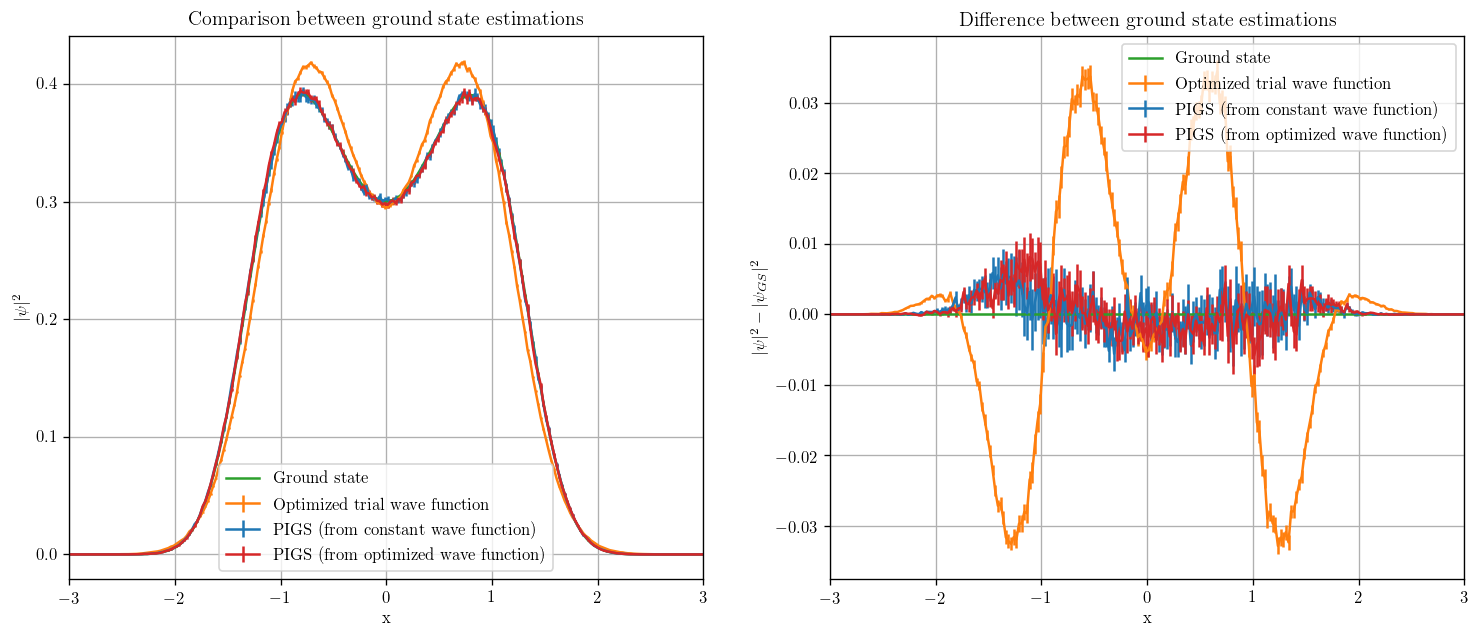

In [6]:
x_pigs_const, p_pigs_const, err_p_pigs_const=np.loadtxt("Ex_08_3/Results/ConstantWF/probability.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_opt, p_pigs_opt, err_p_pigs_opt=np.loadtxt("Ex_08_3/Results/OptimizedWF/probability.dat", delimiter=" ", dtype="float,float,float", unpack=True)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.grid(True)
ax1.set_title("Comparison between ground state estimations")
ax1.set_xlabel("x")
ax1.set_ylabel(r"$|\psi|^2$")
ax1.errorbar(xsampl,psampl,yerr=psampl_err, label="Optimized trial wave function", color="C1")
ax1.errorbar(x_pigs_const,p_pigs_const,err_p_pigs_const, label="PIGS (from constant wave function)")
ax1.errorbar(x_pigs_opt,p_pigs_opt,err_p_pigs_opt, label="PIGS (from optimized wave function)",color="C3")
ax1.plot(x,(psi[0])**2, color="C2", label="Ground state")
ax1.set_xlim((-3,3))
ax1.legend()

ax2.grid(True)
ax2.set_title("Difference between ground state estimations")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$|\psi|^2-|\psi_{GS}|^2$")
ax2.errorbar(xsampl,psampl-(psi[0])**2,yerr=psampl_err, label="Optimized trial wave function", color="C1")
ax2.errorbar(x_pigs_const,p_pigs_const-(psi[0])**2,yerr=err_p_pigs_const, label="PIGS (from constant wave function)", color="C0")
ax2.errorbar(x_pigs_opt,p_pigs_opt-(psi[0])**2,yerr=err_p_pigs_opt, label="PIGS (from optimized wave function)", color="C3")
ax2.axhline(0,0,1, color="C2", label="Ground state")
ax2.set_xlim((-3,3))
ax2.legend()

plt.show()
plt.show()

<span style="color:red">Si può notare che la distribuzione di probabilità del ground state risulta entro le incertezze statistiche di quelle stimate con il metodo PIGS. Questo è quello che si intende dicendo che tale metodo è esatto</span>. Ovviamente, se si volessero diminuire le incertezze, non bisognerebbe solo aumentare il numero di step Monte Carlo della simulazione (qui ne sono stati considerati $4000$ per ognuno di $20$ blocchi), ma occorrerebbe anche aumentare il numero di timeslice in modo da ridurre il bias introdotto dall'approssimazione primitiva e, eventualmente, proiettare per un tempo immaginario maggiore lo stato iniziale. Il punto è che il bias di queste approssimazioni può essere ridotto a piacere, fino a quando diventa minore rispetto all'incertezza statistica. Il limite ultimo è quindi legato alla potenza/tempo di calcolo che si vuole dedicare al problema. Questo è radicalmente diverso da quanto visto nel caso variazionale: in questo caso il limite ultimo è costituito dalla scelta della funzione d'onda di prova, anche ottimizzando al meglio i parametri, nella maggior parte dei casi non si può ottenere il ground state vero e proprio, ma solo una sua approssimazione.

Per quanto riguarda l'energia, invece (non riporto più il valore calcolato nell'esercizio 08.2):

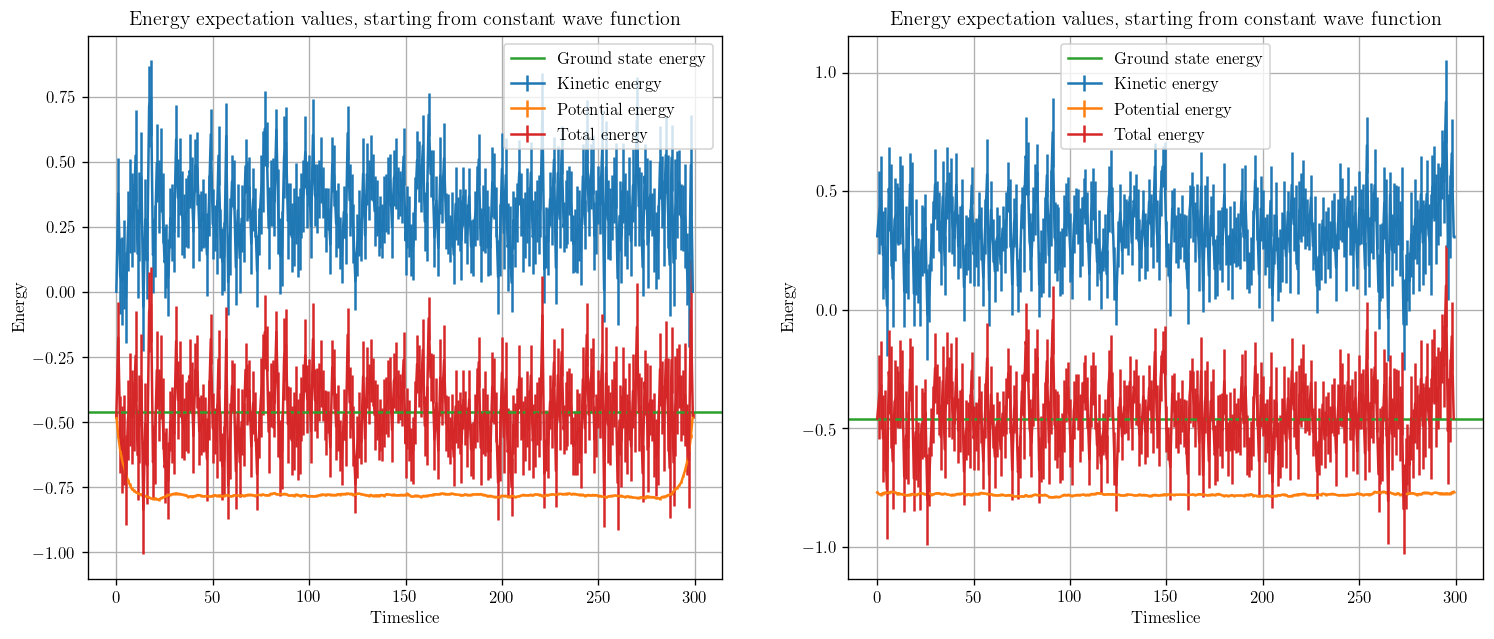

In [7]:
timeslices,ekin_const,ekin_err_const=np.loadtxt("Ex_08_3/Results/ConstantWF/kinetic.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,epot_const,epot_err_const=np.loadtxt("Ex_08_3/Results/ConstantWF/potential.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,etot_const,etot_err_const=np.loadtxt("Ex_08_3/Results/ConstantWF/total.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,ekin_opt,ekin_err_opt=np.loadtxt("Ex_08_3/Results/OptimizedWF/kinetic.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,epot_opt,epot_err_opt=np.loadtxt("Ex_08_3/Results/OptimizedWF/potential.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,etot_opt,etot_err_opt=np.loadtxt("Ex_08_3/Results/OptimizedWF/total.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.set_title("Energy expectation values, starting from constant wave function")
ax1.errorbar(timeslices,ekin_const,yerr=ekin_err_const, label="Kinetic energy")
ax1.errorbar(timeslices,epot_const,yerr=epot_err_const, label="Potential energy")
ax1.errorbar(timeslices,etot_const,yerr=etot_err_const, label="Total energy",color="C3")
ax1.axhline(E[0],0,1, label="Ground state energy",color="C2")
ax1.grid()
ax1.set_xlabel(r"Timeslice")
ax1.set_ylabel("Energy")
ax1.legend()

ax2.set_title("Energy expectation values, starting from constant wave function")
ax2.errorbar(timeslices,ekin_opt,yerr=ekin_err_opt, label="Kinetic energy")
ax2.errorbar(timeslices,epot_opt,yerr=epot_err_opt, label="Potential energy")
ax2.errorbar(timeslices,etot_opt,yerr=etot_err_opt, label="Total energy",color="C3")
ax2.axhline(E[0],0,1, label="Ground state energy",color="C2")
ax2.grid()
ax2.set_xlabel(r"Timeslice")
ax2.set_ylabel("Energy")
ax2.legend()

plt.show()

<span style="color:red">Dall'andamento dell'energia potenziale (curva arancione) nel grafico a sinistra (in cui la funzione iniziale è la funzione d'onda costante) si nota che per le timeslice piccole e per quelle grandi il valore è molto diverso rispetto alle timeslice centrali</span>. Questo è dovuto al fatto che per calcolare il valore di aspettazione di un operatore occorre fare evolvere per tempi immaginari sia il "bra" che il "ket", ovvero vogliamo considerare il valore $\langle \psi(\tau/2)| V | \psi(\tau/2)\rangle$. Per le timeslice piccole o grandi si considera invece il valore di aspettazione ottenuto considerando $\langle \psi(\tau)| V | \psi(0)\rangle = \langle \psi(0)| V | \psi(\tau)\rangle$: $|\psi(\tau)\rangle$ viene fatto evolvere per il doppio del tempo immaginario (e quindi è più vicino al ground state rispetto a $|\psi(\tau/2)\rangle$), tuttavia l'altro stato rimane quello di prova iniziale, che può essere molto diverso dal ground state effettivo. Lo stesso si può osservare, meno chiaramente, dall'energia cientica.

<span style="color:red">L'energia totale</span>, invece, non ha questo problema. Essa <span style="color:red">si può valutare in qualsiasi punto della catena</span>, dal momento che commuta con tutti gli esponenziali che emergono facendo la decomposizione di Trotter. In particolare, i punti migliori in cui valutarla sembrano essere il primo e l'ultimo, in cui le incertezze sull'energia cinetica sono minime (anche se non si vede chiaramente dai grafici sopra riportati).

Infine, si può anche notare che, se <span style="color:red">si parte dalla funzione d'onda variazionale ottimizzata, non si vede il transiente iniziale nell'energia potenziale e cinetica</span>. In questo caso, infatti, la funzione d'onda di partenza è già abbastanza simile al ground state sin dall'inizio. Le proiezioni successive la avvicinano sempre di più al ground state, ma non si vede più quanto discusso per la funzione d'onda iniziale costante.

Può quindi essere interessante andare a vedere per quanto tempo è necessario proiettare le funzioni d'onda iniziali per arrivare a dei risultati soddisfacenti. Per fare questo ho calcolato le distribuzioni di probabilità nei due casi per diversi valori di $\tau$. Ho notato che, per $\tau$ piccoli, non è stato possibile mantenere l'accettazione delle mosse intorno al $50\%$.

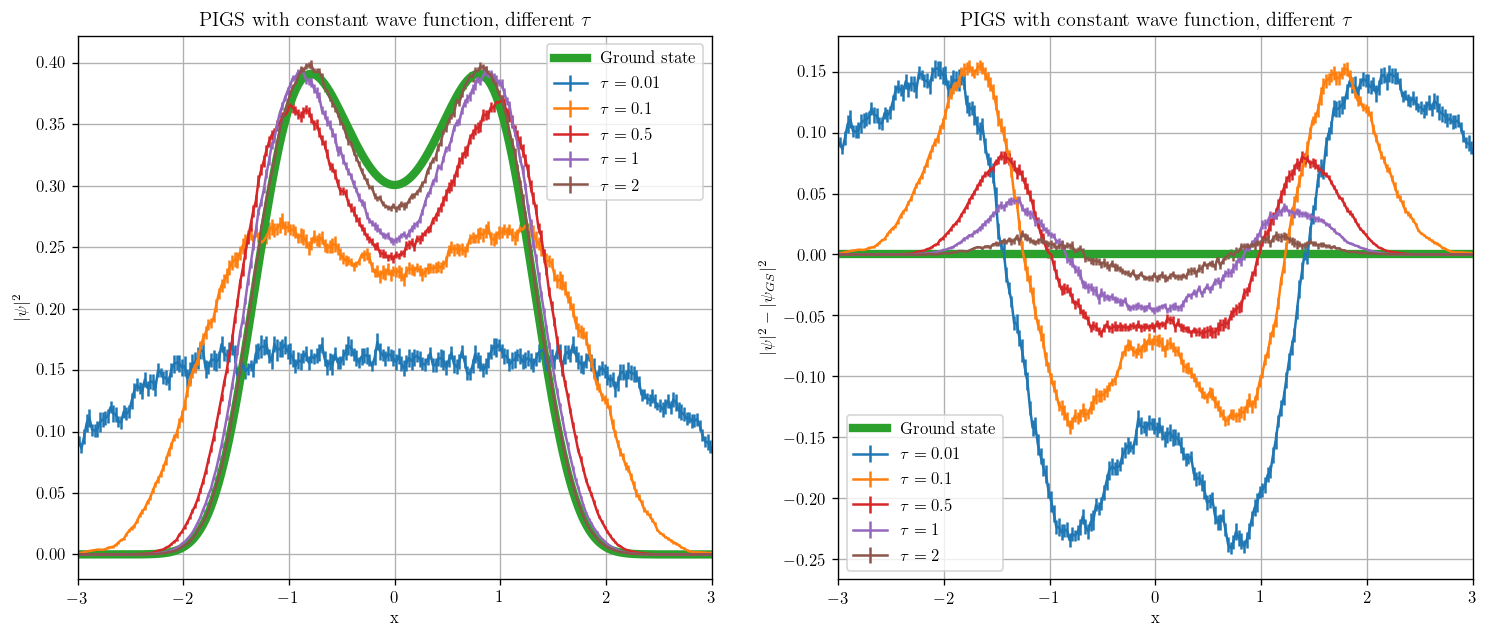

In [8]:
x_pigs_const001, p_pigs_const001, err_p_pigs_const001=np.loadtxt("Ex_08_3/DifferentTaus/ConstantWF/probability001.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_const01, p_pigs_const01, err_p_pigs_const01=np.loadtxt("Ex_08_3/DifferentTaus/ConstantWF/probability01.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_const05, p_pigs_const05, err_p_pigs_const05=np.loadtxt("Ex_08_3/DifferentTaus/ConstantWF/probability05.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_const1, p_pigs_const1, err_p_pigs_const1=np.loadtxt("Ex_08_3/DifferentTaus/ConstantWF/probability1.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_const2, p_pigs_const2, err_p_pigs_const2=np.loadtxt("Ex_08_3/DifferentTaus/ConstantWF/probability2.dat", delimiter=" ", dtype="float,float,float", unpack=True)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.grid(True)
ax1.set_title(r"PIGS with constant wave function, different $\tau$")
ax1.set_xlabel("x")
ax1.set_ylabel(r"$|\psi|^2$")
ax1.errorbar(x_pigs_const001, p_pigs_const001, err_p_pigs_const001, label=r"$\tau=0.01$", color="C0")
ax1.errorbar(x_pigs_const01, p_pigs_const01, err_p_pigs_const01, label=r"$\tau=0.1$", color="C1")
ax1.errorbar(x_pigs_const05, p_pigs_const05, err_p_pigs_const05, label=r"$\tau=0.5$", color="C3")
ax1.errorbar(x_pigs_const1, p_pigs_const1, err_p_pigs_const1, label=r"$\tau=1$", color="C4")
ax1.errorbar(x_pigs_const2, p_pigs_const2, err_p_pigs_const2, label=r"$\tau=2$", color="C5")
ax1.plot(x,(psi[0])**2, color="C2", label="Ground state",linewidth=5)
ax1.set_xlim((-3,3))
ax1.legend()

ax2.grid(True)
ax2.set_title(r"PIGS with constant wave function, different $\tau$")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$|\psi|^2-|\psi_{GS}|^2$")
ax2.errorbar(x_pigs_const001, p_pigs_const001-(psi[0])**2, err_p_pigs_const001, label=r"$\tau=0.01$", color="C0")
ax2.errorbar(x_pigs_const01, p_pigs_const01-(psi[0])**2, err_p_pigs_const01, label=r"$\tau=0.1$", color="C1")
ax2.errorbar(x_pigs_const05, p_pigs_const05-(psi[0])**2, err_p_pigs_const05, label=r"$\tau=0.5$", color="C3")
ax2.errorbar(x_pigs_const1, p_pigs_const1-(psi[0])**2, err_p_pigs_const1, label=r"$\tau=1$", color="C4")
ax2.errorbar(x_pigs_const2, p_pigs_const2-(psi[0])**2, err_p_pigs_const2, label=r"$\tau=2$", color="C5")

ax2.axhline(0,0,1, color="C2", label="Ground state", linewidth=5)
ax2.set_xlim((-3,3))
ax2.legend()

plt.show()

Nel grafico a sinistra è riportata la distribuzione di probabilità calcolata per diversi tempi di propagazione immaginari. Si può notare che <span style="color:red">per tempi piccoli (curva blu) la funzione d'onda proiettata è ancora abbastanza simile a quella iniziale costante</span>. <span style="color:red">Man mano che aumenta il tempo di propagazione immaginario</span> (e quindi la funzione d'onda iniziale viene proiettata "di più" sul ground state), <span style="color:red">si ottengono delle distribuzioni di probabilità sempre più simili a quella attesa</span> (calcolata con la solita discretizzazione dell'equazione di Schrödinger).

Nel grafico a destra, invece, si possono osservare le discrepanze tra le medesime distribuzioni di probabilità calcolate per diversi $\tau$ e quella attesa. Si può notare che le discrepanze tendono a diminuire sempre di più, ma <span style="color:red">anche a $\tau=2$ (curva marrone) la distribuzione di probabilità non risulta compatibile con quella attesa in molte zone</span>. 

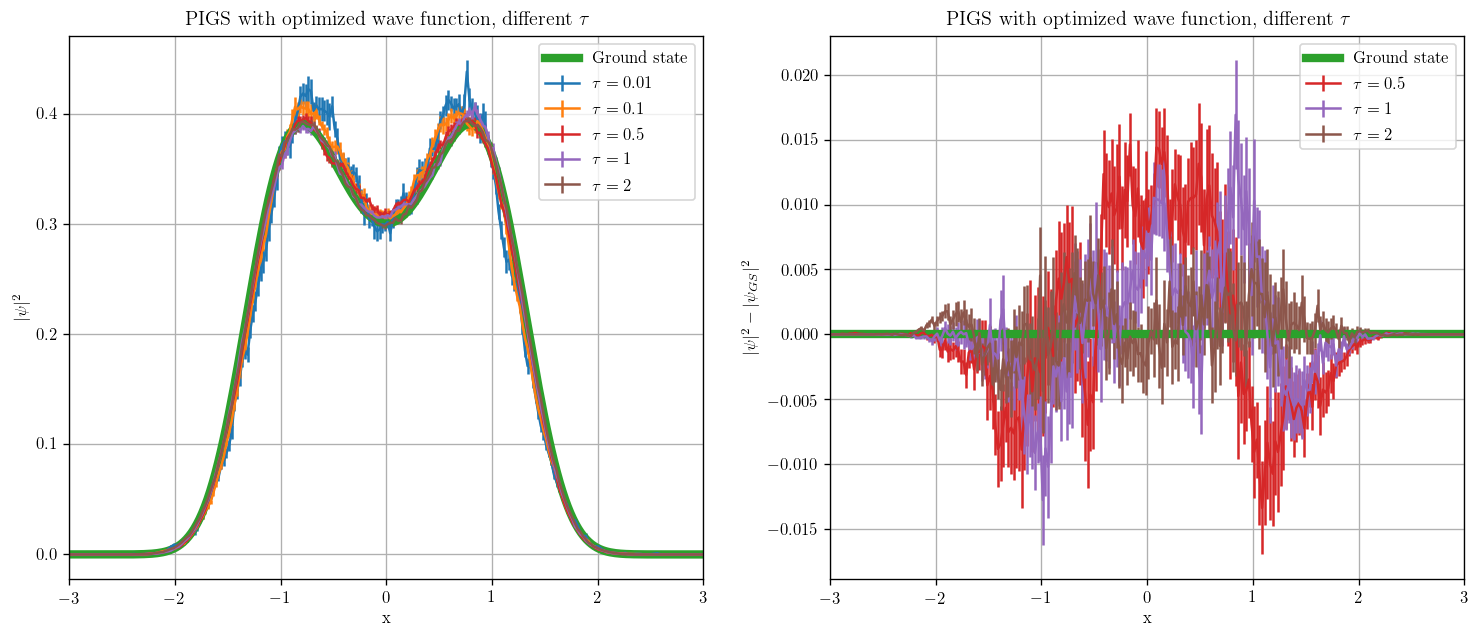

In [9]:
x_pigs_opt001, p_pigs_opt001, err_p_pigs_opt001=np.loadtxt("Ex_08_3/DifferentTaus/OptimizedWF/probability001.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_opt01, p_pigs_opt01, err_p_pigs_opt01=np.loadtxt("Ex_08_3/DifferentTaus/OptimizedWF/probability01.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_opt05, p_pigs_opt05, err_p_pigs_opt05=np.loadtxt("Ex_08_3/DifferentTaus/OptimizedWF/probability05.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_opt1, p_pigs_opt1, err_p_pigs_opt1=np.loadtxt("Ex_08_3/DifferentTaus/OptimizedWF/probability1.dat", delimiter=" ", dtype="float,float,float", unpack=True)
x_pigs_opt2, p_pigs_opt2, err_p_pigs_opt2=np.loadtxt("Ex_08_3/DifferentTaus/OptimizedWF/probability2.dat", delimiter=" ", dtype="float,float,float", unpack=True)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.grid(True)
ax1.set_title(r"PIGS with optimized wave function, different $\tau$")
ax1.set_xlabel("x")
ax1.set_ylabel(r"$|\psi|^2$")
ax1.errorbar(x_pigs_opt001, p_pigs_opt001, err_p_pigs_opt001, label=r"$\tau=0.01$", color="C0")
ax1.errorbar(x_pigs_opt01, p_pigs_opt01, err_p_pigs_opt01, label=r"$\tau=0.1$", color="C1")
ax1.errorbar(x_pigs_opt05, p_pigs_opt05, err_p_pigs_opt05, label=r"$\tau=0.5$", color="C3")
ax1.errorbar(x_pigs_opt1, p_pigs_opt1, err_p_pigs_opt1, label=r"$\tau=1$", color="C4")
ax1.errorbar(x_pigs_opt2, p_pigs_opt2, err_p_pigs_opt2, label=r"$\tau=2$", color="C5")
ax1.plot(x,(psi[0])**2, color="C2", label="Ground state",linewidth=5)
ax1.set_xlim((-3,3))
ax1.legend()

ax2.grid(True)
ax2.set_title(r"PIGS with optimized wave function, different $\tau$")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$|\psi|^2-|\psi_{GS}|^2$")
#ax2.errorbar(x_pigs_opt001, p_pigs_opt001-(psi[0])**2, err_p_pigs_opt001, label=r"$\tau=0.01$", color="C0")
#ax2.errorbar(x_pigs_opt01, p_pigs_opt01-(psi[0])**2, err_p_pigs_opt01, label=r"$\tau=0.1$", color="C1")
ax2.errorbar(x_pigs_opt05, p_pigs_opt05-(psi[0])**2, err_p_pigs_opt05, label=r"$\tau=0.5$", color="C3")
ax2.errorbar(x_pigs_opt1, p_pigs_opt1-(psi[0])**2, err_p_pigs_opt1, label=r"$\tau=1$", color="C4")
ax2.errorbar(x_pigs_opt2, p_pigs_opt2-(psi[0])**2, err_p_pigs_opt2, label=r"$\tau=2$", color="C5")

ax2.axhline(0,0,1, color="C2", label="Ground state", linewidth=5)
ax2.set_xlim((-3,3))
ax2.legend()

plt.show()

Diversa è la situazione se invece si considera come funzione iniziale quella ottimizzata. In questo caso <span style="color:red">lo stato iniziale è già molto simile al ground state</span>, come si può osservare nel grafico a sinistra. Nel grafico a destra, rappresentante le discrepanze con la distribuzione di probabilità attesa, ho dovuto riportare solo alcuni valori di $\tau$ per rendere leggibile il grafico. In particolare si può notare che per $\tau=1$ (curva viola) ci sono ancora alcuni punti abbastanza critici, in particolare in prossimità dei punti stazionari della distribuzione di probabilità attesa; invece, già <span style="color:red">per $\tau=2$ (curva marrone), la distribuzione di probabilità calcolata discretizzando l'equazione di Schrödinger risulta entro le incertezze statistiche di quella ottenuta con il metodo PIGS.</span>

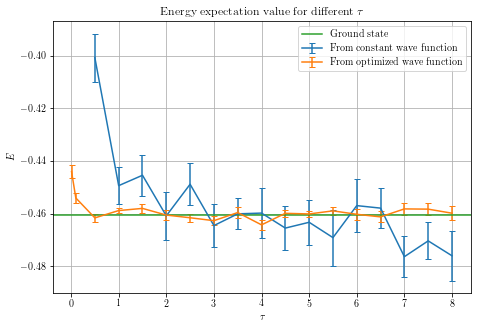

In [10]:
tau_const,e_const,err_const=np.loadtxt("Ex_08_3/Results/ConstantWF/totalbest.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)
tau_opt,e_opt,err_opt=np.loadtxt("Ex_08_3/Results/OptimizedWF/totalbest.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax1 = plt.subplots(1,1, figsize=(7.5,5))
ax1.grid(True)

ax1.errorbar(tau_const[:16],e_const[:16],err_const[:16], label="From constant wave function", capsize=3)
ax1.errorbar(tau_opt,e_opt,err_opt, label="From optimized wave function", capsize=3)
ax1.set_title(r"Energy expectation value for different $\tau$")
ax1.set_xlabel(r"$\tau$")
ax1.set_ylabel(r"$E$")
ax1.axhline(E[0],0,1,color="C2",label="Ground state")
ax1.legend()
plt.show()

Ho infine fatto un confronto per studiare come cambia la stima dell'energia totale in funzione di $\tau$. Ho considerato il valore dell'eneriga totale per la prima timeslice, per i motivi spiegati sopra. Ho cercato di mantenere l'accettazione delle varie mosse tra il $40\%$ e il $60\%$, ma per $\tau$ piccoli questo non è stato possibile.

In entrambi i casi, <span style="color:red">per $\tau$ piccoli si può osservare come l'energia diminuisca rapidamente fino a raggiungere quella del ground state. Se si parte da una funzione d'onda costante, è necessario più tempo immaginario per raggiungere un'energia confrontabile con quella del ground state rispetto al caso in cui si parte da una funzione d'onda ottimizzata.</span> Nel primo caso non ho riportato i primissimi punti  perché l'energia corrispondente alla funzione d'onda costante è molto più alta rispetto a quella delle funzioni d'onda successive, non sarebbe quindi stato possibile visualizzare gli altri dati.
Partendo dalla funzione d'onda ottimizzata, il primo punto (ottenuto con $\tau=0.01$) è compatibile con l'energia stimata nell'esercizio precedente ($E_T \approx -0.44$).  Si può anche notare che le incertezze ottenute partendo da una funzione d'onda ottimizzata sono minori.

### PIMC ($T\neq 0$)

Quando si considera un sistema a temperatura finita $T\neq 0$, il sistema si trova in uno stato misto $\rho=\frac{1}{Z}e^{-\beta H}$, dove $Z=Tr(e^{-\beta H})$ (matrice densità canonica). Nel nostro caso $H$ è l'Hamiltoniana di singola particella soggetta al potenziale indicato all'inizio del notebook. Se la temperatura è nulla, l'operatore densità coincide con il ground state. Invece, se $T\neq 0$, anche gli stati eccitati danno un contributo. Nel limite di $T\to +\infty$ tutti gli autostati dell'energia danno lo stesso contributo. Nel caso a temperatura finita, non entra in gioco alcuna funzione d'onda iniziale: non stiamo più proiettando uno stato iniziale per arrivare al ground state, vogliamo invece campionare una particolare distribuzione di probabilità legata all'operatore densità canonico. Per il calcolo delle distribuzioni di probabilità si sono quindi considerati tutte le "timeslice", non solo quelle centrali come nel caso precedente (in questo caso non ha neanche senso parlare di timeslice centrali, dato che il sistema quantistico è isomorfo a un polimero ad anello).

Riporto quindi alcuni stati eccitati calcolati discretizzando l'equazione di Schrödinger.

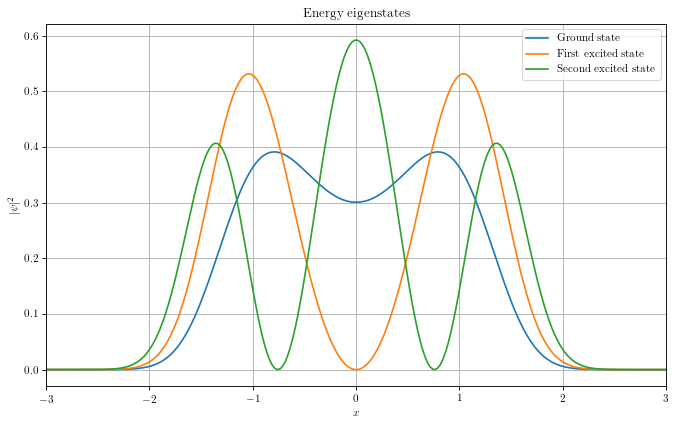

Ground state energy:  -0.46052678306551875
1st excited state energy:  0.0972414186173216
2nd excited state energy:  1.9711221329456956


In [18]:
plt.figure(figsize=(10,6),dpi=80)
plt.title("Energy eigenstates")
plt.plot(x,psi[0]**2, label="Ground state")
plt.plot(x,psi[1]**2, label="First excited state")
plt.plot(x,psi[2]**2, label="Second excited state")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi|^2$")
plt.grid(True)
plt.legend()
plt.xlim(-3,3)
plt.show()

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

In seguito sono invece riportati le distribuzioni di probabilità calcolate con il metodo PIMC.

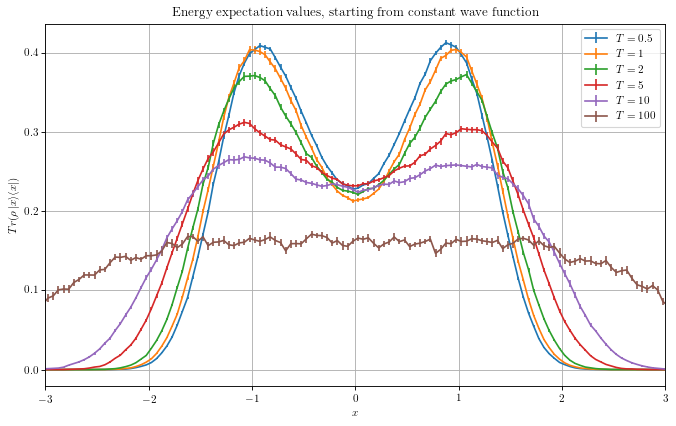

In [43]:
x05,p05,err_p05=np.loadtxt("Ex_08_3/PIMC/probability05.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)
x1,p1,err_p1=np.loadtxt("Ex_08_3/PIMC/probability1.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)
x2,p2,err_p2=np.loadtxt("Ex_08_3/PIMC/probability2.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)
x5,p5,err_p5=np.loadtxt("Ex_08_3/PIMC/probability5.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)
x10,p10,err_p10=np.loadtxt("Ex_08_3/PIMC/probability10.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)
x100,p100,err_p100=np.loadtxt("Ex_08_3/PIMC/probability100.dat", delimiter=" ", usecols=(0,1,2), dtype="float,float,float", unpack=True)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(1,1, figsize=(10,6),dpi=80)

ax.set_title("Energy expectation values, starting from constant wave function")
ax.errorbar(x05,p05,err_p05, label=r"$T=0.5$")
ax.errorbar(x1,p1,err_p1, label=r"$T=1$")
ax.errorbar(x2,p2,err_p2, label=r"$T=2$")
ax.errorbar(x5,p5,err_p5, label=r"$T=5$")
ax.errorbar(x10,p10,err_p10, label=r"$T=10$")
ax.errorbar(x100,p100,err_p100, label=r"$T=100$")

ax.grid()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$Tr(\rho \left| x \right> \! \left< x \right|)$")
ax.set_xlim(-3,3)
ax.legend()

plt.show()

Si può innanzitutto notare che, <span style="color:red">a temperature basse, il contributo più importante dopo quello del ground state è dato dal primo stato eccitato</span>, infatti i due massimi della distribuzione di probabilità tendono ad allontanarsi. 

<span style="color:red">Aumentando la temperatura, invece, la distribuzione di probabilità si avvicina all'identità</span>. In effetti, se tutti gli autostati dell'energia sono ugualmente probabili (ovvero nel limite $T \to +\infty$), l'operatore densità si riduce alla somma di tutti questi autostati opportunamente normalizzata, ovvero $\rho \propto \sum_n \left| E_n \right> \left< E_n \right| = \mathbb{1}$ e quindi $p(x)=Tr(\rho \left|x\right> \left<x \right|)=cost.$

Infine, riporto il calcolo del valore di aspettazione dell'energia.

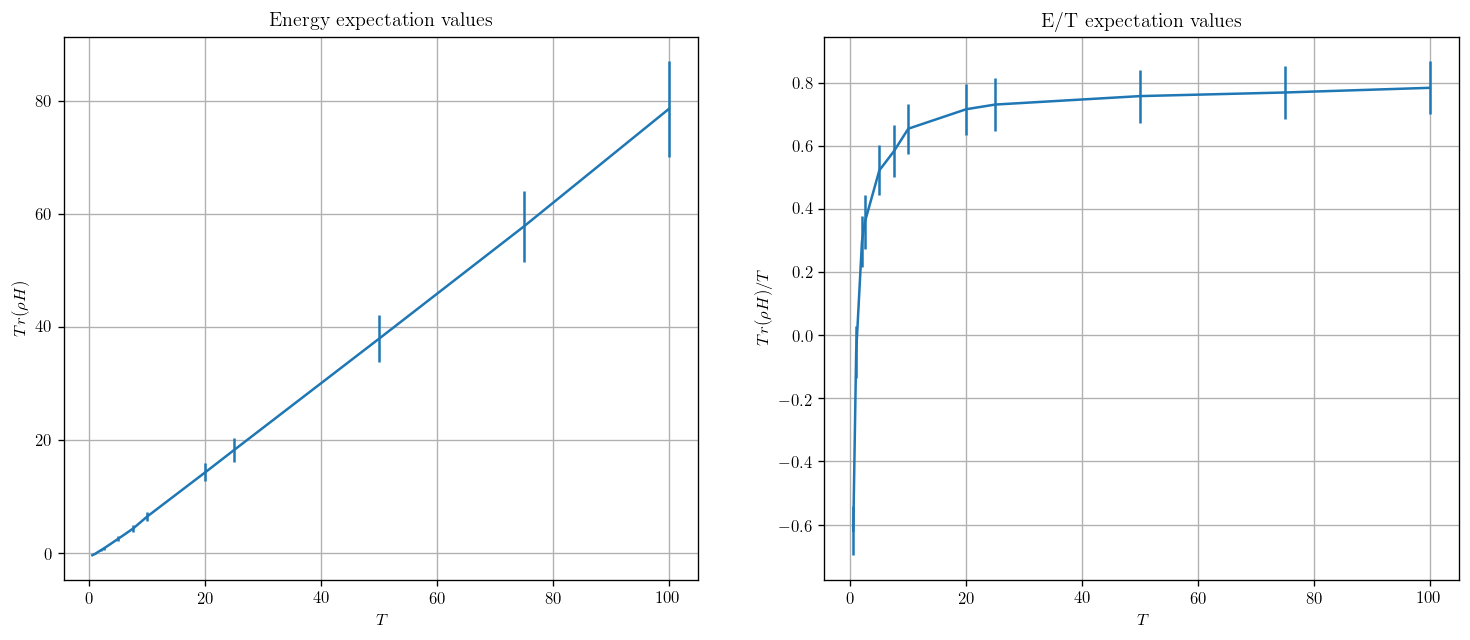

In [58]:
energies, error_energies, temperatures = np.loadtxt("Ex_08_3/PIMC/totalbest.dat", delimiter=" ", usecols=(1,2,3), dtype="float,float,float", unpack=True)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.set_title("Energy expectation values")
ax1.errorbar(temperatures, energies, error_energies)
ax1.grid()
ax1.set_xlabel(r"$T$")
ax1.set_ylabel(r"$Tr(\rho H)$")

ax2.set_title("E/T expectation values")
ax2.errorbar(temperatures, energies/temperatures, error_energies/temperatures)
ax2.grid()
ax2.set_xlabel(r"$T$")
ax2.set_ylabel(r"$Tr(\rho H)/T$")

plt.show()

Si può osservare che <span style="color:red">a grandi temperature il valore di aspettazione dell'energia cresce approsimativamente linearmente con la temperatura</span>, mentre questo non è vero a basse temperature.